Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'D:\\AI\\data\\notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [31]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [33]:
#设置超参数Beta为10^-3

In [34]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 20.129984
Minibatch accuracy: 10.9%
Validation accuracy: 12.8%
Minibatch loss at step 500: 2.547391
Minibatch accuracy: 81.2%
Validation accuracy: 76.0%
Minibatch loss at step 1000: 1.816388
Minibatch accuracy: 79.7%
Validation accuracy: 77.7%
Minibatch loss at step 1500: 0.962926
Minibatch accuracy: 85.2%
Validation accuracy: 79.2%
Minibatch loss at step 2000: 0.799073
Minibatch accuracy: 88.3%
Validation accuracy: 80.4%
Minibatch loss at step 2500: 0.730822
Minibatch accuracy: 82.8%
Validation accuracy: 80.9%
Minibatch loss at step 3000: 0.798177
Minibatch accuracy: 82.8%
Validation accuracy: 81.6%
Test accuracy: 88.7%


In [35]:
#探索一下超参数的最优值

In [36]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

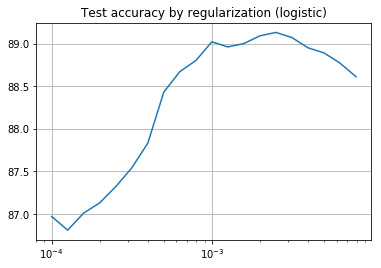

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

In [ ]:
#多一层relu隐藏层

In [41]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [42]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 696.433472
Minibatch accuracy: 7.8%
Validation accuracy: 29.7%
Minibatch loss at step 500: 200.254868
Minibatch accuracy: 79.7%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 114.880768
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 68.106483
Minibatch accuracy: 89.1%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 41.220245
Minibatch accuracy: 88.3%
Validation accuracy: 84.5%
Minibatch loss at step 2500: 25.021698
Minibatch accuracy: 90.6%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 15.505817
Minibatch accuracy: 83.6%
Validation accuracy: 86.3%
Test accuracy: 93.1%


In [43]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:    
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

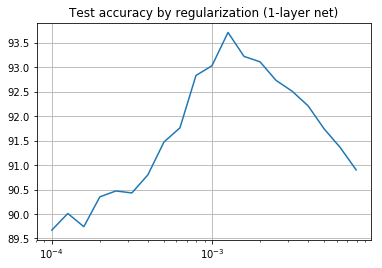

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [81]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [83]:
num_steps = 100
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 5 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 377.225647
Minibatch accuracy: 6.2%
Validation accuracy: 26.2%
Minibatch loss at step 5: 134.668640
Minibatch accuracy: 71.1%
Validation accuracy: 69.8%
Minibatch loss at step 10: 31.509201
Minibatch accuracy: 84.4%
Validation accuracy: 70.3%
Minibatch loss at step 15: 12.981134
Minibatch accuracy: 95.3%
Validation accuracy: 73.6%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 25: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 30: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 35: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 45: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 50: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [84]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  logits = tf.matmul(drop1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [86]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 5 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 486.189148
Minibatch accuracy: 8.6%
Validation accuracy: 24.2%
Minibatch loss at step 5: 135.959656
Minibatch accuracy: 80.5%
Validation accuracy: 63.5%
Minibatch loss at step 10: 19.929626
Minibatch accuracy: 94.5%
Validation accuracy: 66.9%
Minibatch loss at step 15: 0.052234
Minibatch accuracy: 99.2%
Validation accuracy: 66.7%
Minibatch loss at step 20: 0.936623
Minibatch accuracy: 98.4%
Validation accuracy: 68.2%
Minibatch loss at step 25: 1.780639
Minibatch accuracy: 98.4%
Validation accuracy: 65.7%
Minibatch loss at step 30: 16.265604
Minibatch accuracy: 98.4%
Validation accuracy: 68.8%
Minibatch loss at step 35: 4.513223
Minibatch accuracy: 99.2%
Validation accuracy: 67.5%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 66.7%
Minibatch loss at step 45: 1.269597
Minibatch accuracy: 97.7%
Validation accuracy: 67.4%
Minibatch loss at step 50: 3.236887
Minibatch accuracy: 98.4%
Validation accuracy: 68.4%
Minib

In [87]:
#按理说，与Problem2的Test accuracy相比，应该是增大的，也就是dropout一些神经元后，可以一定程度上减小Overfit，但Test accuracy结果是降低的
#可能是神经网络太简单的原因

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [90]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    ) #stddev为了使神经网络更快收敛
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True) #应用于学习率的指数衰减函数
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [91]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.277215
Minibatch accuracy: 7.8%
Validation accuracy: 30.7%
Minibatch loss at step 500: 0.919247
Minibatch accuracy: 88.3%
Validation accuracy: 85.5%
Minibatch loss at step 1000: 0.859447
Minibatch accuracy: 86.7%
Validation accuracy: 86.3%
Minibatch loss at step 1500: 0.560781
Minibatch accuracy: 93.8%
Validation accuracy: 87.5%
Minibatch loss at step 2000: 0.518377
Minibatch accuracy: 93.8%
Validation accuracy: 87.6%
Minibatch loss at step 2500: 0.458424
Minibatch accuracy: 92.2%
Validation accuracy: 88.3%
Minibatch loss at step 3000: 0.562293
Minibatch accuracy: 87.5%
Validation accuracy: 88.6%
Minibatch loss at step 3500: 0.559631
Minibatch accuracy: 88.3%
Validation accuracy: 89.0%
Minibatch loss at step 4000: 0.486010
Minibatch accuracy: 91.4%
Validation accuracy: 89.2%
Minibatch loss at step 4500: 0.450961
Minibatch accuracy: 90.6%
Validation accuracy: 89.1%
Minibatch loss at step 5000: 0.509986
Minibatch accuracy: 89.8%
Validation accuracy

In [ ]:
#再加一层神经网络

In [94]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
    beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)+ tf.nn.l2_loss(weights4))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 800, 0.8, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [96]:
num_steps = 20000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.474672
Minibatch accuracy: 10.9%
Validation accuracy: 35.1%
Minibatch loss at step 500: 1.063434
Minibatch accuracy: 88.3%
Validation accuracy: 85.6%
Minibatch loss at step 1000: 0.940260
Minibatch accuracy: 85.2%
Validation accuracy: 86.3%
Minibatch loss at step 1500: 0.613848
Minibatch accuracy: 93.0%
Validation accuracy: 87.8%
Minibatch loss at step 2000: 0.557993
Minibatch accuracy: 93.8%
Validation accuracy: 87.8%
Minibatch loss at step 2500: 0.506357
Minibatch accuracy: 90.6%
Validation accuracy: 88.3%
Minibatch loss at step 3000: 0.583875
Minibatch accuracy: 88.3%
Validation accuracy: 88.6%
Minibatch loss at step 3500: 0.559813
Minibatch accuracy: 87.5%
Validation accuracy: 88.9%
Minibatch loss at step 4000: 0.488061
Minibatch accuracy: 91.4%
Validation accuracy: 89.4%
Minibatch loss at step 4500: 0.450292
Minibatch accuracy: 92.2%
Validation accuracy: 89.0%
Minibatch loss at step 5000: 0.493456
Minibatch accuracy: 90.6%
Validation accurac